# Проект: Прогнозирование покупок клиентов интернет-магазина через 90 дней

## Описание проекта

Интернет-магазин собирает данные о покупках клиентов и рекламных коммуникациях. Основной задачей является выделение пользователей, которые готовы совершить покупку в ближайшее время, чтобы оптимизировать маркетинговые кампании и повысить конверсию от рассылок.

**Цель проекта**: 
- Построить модель, которая будет предсказывать вероятность совершения покупки клиентом в течение 90 дней после получения рекламного сообщения.

**Основные задачи**:
1. Изучить предоставленные данные.
2. Провести инжиниринг признаков на основе истории покупок, данных о рекламных кампаниях и активности пользователей.
3. Построить модель для бинарной классификации, которая будет прогнозировать вероятность покупки.
4. Оптимизировать модель, добиваясь максимальной метрики **ROC-AUC**.
5. Провести финальное тестирование и представить результаты.

## Данные

Проект использует несколько источников данных:

### 1. **Apparel Purchases Dataset** (История покупок)
- **Описание**: Данные о покупках клиентов, включая количество товаров, цены и категории товаров.
- **Основные колонки**:
  - `client_id`: Уникальный идентификатор клиента.
  - `quantity`: Количество товаров в заказе.
  - `price`: Цена товара.
  - `category_ids`: Вложенные категории товара.
  - `date`: Дата покупки.
  - `message_id`: Идентификатор рекламного сообщения.

### 2. **Apparel Target Binary Dataset** (Целевые данные)
- **Описание**: Бинарные метки, указывающие на то, совершил ли клиент покупку в течение 90 дней.
- **Основные колонки**:
  - `client_id`: Уникальный идентификатор клиента.
  - `target`: 1 — если клиент совершил покупку, 0 — если не совершил.

### 3. **Full Campaign Daily Event Dataset** (Ежедневные события рекламных кампаний)
- **Описание**: Данные о взаимодействиях клиентов с рекламными кампаниями по дням.
- **Основные колонки**:
  - `bulk_campaign_id`: Идентификатор рекламной кампании.
  - `date`: Дата события.
  - `count_*`: Количество событий (клики, открытия, покупки и т.д.).
  - `nunique_*`: Количество уникальных клиентов для каждого события.

### 4. **Full Campaign Daily Event Channel Dataset** (Ежедневные события с разбивкой по каналам)
- **Описание**: Похожие данные на предыдущий датасет, но с детализацией по каналам (email, push-уведомления и т.д.).
- **Основные колонки**:
  - `bulk_campaign_id`: Идентификатор рекламной кампании.
  - `date`: Дата события.
  - `count_*_channel_*`: Количество событий для каждого канала.
  - `nunique_*_channel_*`: Количество уникальных клиентов для каждого события и канала.

### 5. **Apparel Messages Dataset** (История рекламных коммуникаций)
- **Описание**: История рекламных сообщений, отправленных клиентам.
- **Основные колонки**:
  - `bulk_campaign_id`: Идентификатор рекламной кампании.
  - `client_id`: Уникальный идентификатор клиента.
  - `message_id`: Идентификатор сообщения.
  - `event`: Тип события (например, открытие или клик).
  - `channel`: Канал рассылки (email, push и т.д.).
  - `date`: Дата события.
  - `created_at`: Время создания сообщения.

In [108]:
import pandas as pd
import ast
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   OneHotEncoder)
from sklearn.model_selection import train_test_split
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, 
                             make_scorer, 
                             confusion_matrix, 
                             classification_report)
from imblearn.over_sampling import SMOTE
from collections import Counter
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
pd.option_context('mode.use_inf_as_na', True)

In [3]:
def extract_unique_categories(category_list_str):
    # Преобразуем строку списка в настоящий список
    category_list = ast.literal_eval(category_list_str)
    # Возвращаем множество уникальных категорий
    return set(category_list)

In [4]:
def top_10_frequent_values(df, columns):
    for col in columns:
        print(f"\nТоп 10 частых значений в % {col}:\n")
        top_10 = df[col].value_counts(normalize=True).head(10) * 100
        display(top_10)

In [5]:
def plot_numerical_feature(data, feature):
    """
    Строит гистограмму и коробчатую диаграмму для числового признака.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Гист
    sns.histplot(data[feature], kde=True, ax=axs[0], color='skyblue')
    axs[0].set_title(f'Гистограмма {feature}')

    # Бокс
    sns.boxplot(x=data[feature], ax=axs[1], color='lightgreen')
    axs[1].set_title(f'Коробчатая диаграмма {feature}')

    plt.tight_layout()
    plt.show()

In [6]:
def plot_categorical_feature(data, feature):
    """
    Строит столбчатую и круговую диаграммы для категориального признака.
    """
    counts = data[feature].value_counts()

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Бар
    sns.barplot(x=counts.index, y=counts.values, ax=axs[0], palette='pastel')
    axs[0].set_title(f'Столбчатая диаграмма {feature}')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

    # Пай
    axs[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    axs[1].set_title(f'Круговая диаграмма {feature}')

    plt.tight_layout()
    plt.show()


In [7]:
data = pd.read_csv('./datasets/apparel-messages.csv')

In [8]:
data_c = data.copy(deep=True)

In [9]:
data['bulk_campaign_id'].unique().size

2709

In [10]:
data['client_id'].unique().size

53329

Всего 2709 компаний И 53329 клиентов 

In [11]:
data.describe()

,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,1.329704e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [13]:
data.head(20)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [14]:
data_1 = pd.read_csv('./datasets/apparel-purchases.csv')

In [15]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [16]:
data_1.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [17]:
data_1.head(20)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [18]:
data_2 = pd.read_csv('./datasets/full_campaign_daily_event.csv')

In [19]:
data_2.head(30)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,0,8,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [20]:
data_2.describe()

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


In [21]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [22]:
data_3 = pd.read_csv('./datasets/full_campaign_daily_event_channel.csv')

In [23]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

In [24]:
data_3.describe()

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


In [25]:
data_3.head(20)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
targets = pd.read_csv('./datasets/apparel-target_binary.csv')

In [27]:
targets

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
...,...,...
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0


In [28]:
data_list = [data,data_1,data_2,data_3,targets]

Я просмотрел данные и увидел одну особенность, есть клиенты, которым не предшествовало никакое рекланмое действие. Это очень ценная инфа для дальнейшего анализа, но я не смогу ее реализовать здесь и сейчас. Вместо этог оя предлагаю сделать так:  просто заполню записи -1 или no_info, где никакая маркетингавая активность не предшествовала, но в идеале я бы передал это аналитикам(или стукнул бы дата инженерам за такие данные)

Объединим всё в один дф

In [29]:
# Шаг 1: Преобразуем даты в тип datetime
data_1['date'] = pd.to_datetime(data_1['date'])
data['created_at'] = pd.to_datetime(data['created_at'])

In [30]:
merged_data = pd.merge(data_1, targets, on='client_id', how='left')

In [31]:
merged_data = pd.merge(merged_data, data, on=['client_id', 'message_id'], how='left', suffixes=('_purchase', '_message'))

In [32]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862248 entries, 0 to 862247
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         862248 non-null  int64         
 1   quantity          862248 non-null  int64         
 2   price             862248 non-null  float64       
 3   category_ids      862248 non-null  object        
 4   date_purchase     862248 non-null  datetime64[ns]
 5   message_id        862248 non-null  object        
 6   target            862248 non-null  int64         
 7   bulk_campaign_id  805820 non-null  float64       
 8   event             805820 non-null  object        
 9   channel           805820 non-null  object        
 10  date_message      805820 non-null  object        
 11  created_at        805820 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 78.9+ MB


In [33]:
merged_data['date_purchase'] = pd.to_datetime(merged_data['date_purchase'])
merged_data['date_message'] = pd.to_datetime(merged_data['date_message']).dt.date

In [34]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862248 entries, 0 to 862247
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         862248 non-null  int64         
 1   quantity          862248 non-null  int64         
 2   price             862248 non-null  float64       
 3   category_ids      862248 non-null  object        
 4   date_purchase     862248 non-null  datetime64[ns]
 5   message_id        862248 non-null  object        
 6   target            862248 non-null  int64         
 7   bulk_campaign_id  805820 non-null  float64       
 8   event             805820 non-null  object        
 9   channel           805820 non-null  object        
 10  date_message      805820 non-null  object        
 11  created_at        805820 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 78.9+ MB


In [35]:
# Оставляем только нужные столбцы
# Выбираем дату из покупок (date_purchase), а дату из рассылок (created_at или date_message) удаляем
merged_data.drop(columns=['date_message'], inplace=True)  # Удаляем дублирующую дату

In [36]:
merged_data['event'].fillna('no_information', inplace=True)
merged_data['channel'].fillna('no_information', inplace=True)
merged_data['bulk_campaign_id'].fillna(-1, inplace=True)

C:\Users\godcl\AppData\Local\Temp\ipykernel_20864\1644192985.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['event'].fillna('no_information', inplace=True)
C:\Users\godcl\AppData\Local\Temp\ipykernel_20864\1644192985.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [37]:
merged_data['has_interaction'] = merged_data['created_at'].apply(lambda x: 0 if pd.isna(x) else 1)

In [38]:
merged_data['created_at'].fillna(pd.to_datetime('1970-01-01'), inplace=True)

C:\Users\godcl\AppData\Local\Temp\ipykernel_20864\4001091804.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['created_at'].fillna(pd.to_datetime('1970-01-01'), inplace=True)


In [39]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862248 entries, 0 to 862247
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         862248 non-null  int64         
 1   quantity          862248 non-null  int64         
 2   price             862248 non-null  float64       
 3   category_ids      862248 non-null  object        
 4   date_purchase     862248 non-null  datetime64[ns]
 5   message_id        862248 non-null  object        
 6   target            862248 non-null  int64         
 7   bulk_campaign_id  862248 non-null  float64       
 8   event             862248 non-null  object        
 9   channel           862248 non-null  object        
 10  created_at        862248 non-null  datetime64[ns]
 11  has_interaction   862248 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(4)
memory usage: 78.9+ MB


In [40]:
merged_data

,client_id,quantity,price,category_ids,date_purchase,message_id,target,bulk_campaign_id,event,channel,created_at,has_interaction
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
862243,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,0,14648.0,click,mobile_push,2024-02-15 16:23:39,1
862244,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
862245,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0
862246,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,0,-1.0,no_information,no_information,1970-01-01 00:00:00,0


In [41]:
# Преобразование столбца date в datetime для обоих датафреймов
data_2['date'] = pd.to_datetime(data_2['date'])
data_3['date'] = pd.to_datetime(data_3['date'])

In [42]:
# Агрегация данных по рекламной кампании в data_2 (full_campaign_daily_event)
campaign_aggregation_2 = data_2.groupby('bulk_campaign_id').agg(
    total_clicks=('count_click', 'sum'),
    total_purchases=('count_purchase', 'sum'),
    total_opens=('count_open', 'sum')
).reset_index()

# Агрегация данных по рекламной кампании в data_3 (full_campaign_daily_event_channel)
campaign_aggregation_3 = data_3.groupby('bulk_campaign_id').agg(
    total_clicks_email=('count_click_email', 'sum'),
    total_clicks_push=('count_click_mobile_push', 'sum'),
    total_opens_email=('count_open_email', 'sum'),
    total_opens_push=('count_open_mobile_push', 'sum'),
    total_purchases_email=('count_purchase_email', 'sum'),
    total_purchases_push=('count_purchase_mobile_push', 'sum')
).reset_index()

In [43]:
campaign_aggregation_3

,bulk_campaign_id,total_clicks_email,total_clicks_push,total_opens_email,total_opens_push,total_purchases_email,total_purchases_push
0,548,0,0,5,0,0,0
1,563,37,0,49,0,1,0
2,577,0,0,133,0,0,0
3,585,9,0,51,0,0,0
4,594,2,0,44,0,0,0
...,...,...,...,...,...,...,...
3176,15146,0,18322,0,435347,0,21
3177,15147,0,11146,0,367678,0,31
3178,15148,12829,0,133038,0,15,0
3179,15149,0,18,0,34,0,0


In [44]:
campaign_aggregation_2

,bulk_campaign_id,total_clicks,total_purchases,total_opens
0,548,0,0,5
1,563,37,1,49
2,577,0,0,133
3,585,9,0,51
4,594,2,0,44
...,...,...,...,...
3176,15146,18322,21,435347
3177,15147,11146,31,367678
3178,15148,12829,15,133038
3179,15149,18,0,34


In [45]:
# Сколько записей с корректными значениями bulk_campaign_id
valid_campaign_ids = merged_data[merged_data['bulk_campaign_id'] != -1]
print(f'Количество записей с реальными bulk_campaign_id: {len(valid_campaign_ids)}')

Количество записей с реальными bulk_campaign_id: 805820


In [46]:
# Соединение основной таблицы с данными из data_2
merged_data = pd.merge(merged_data, campaign_aggregation_2, on='bulk_campaign_id', how='left')

# Соединение основной таблицы с данными из data_3
merged_data = pd.merge(merged_data, campaign_aggregation_3, on='bulk_campaign_id', how='left')


In [47]:
aggregated_columns = ['total_clicks', 'total_purchases', 'total_opens', 
                      'total_clicks_email', 'total_clicks_push', 
                      'total_opens_email', 'total_opens_push', 
                      'total_purchases_email', 'total_purchases_push']

merged_data[aggregated_columns] = merged_data[aggregated_columns].fillna(0)

Поскольку порядок категорий может меняться, но нумерация категорий сквозная, логично рассматривать категории как множество уникальных идентификаторов для каждой покупки.

In [48]:
merged_data['unique_categories'] = merged_data['category_ids'].apply(extract_unique_categories)

In [49]:
# Собираем множество всех уникальных категорий
all_categories = set()
merged_data['unique_categories'].apply(lambda x: all_categories.update(x))

0         None
1         None
2         None
3         None
4         None
          ... 
862243    None
862244    None
862245    None
862246    None
862247    None
Name: unique_categories, Length: 862248, dtype: object

In [50]:
# Преобразуем каждую категорию в строку и исключаем None
sentences = merged_data['unique_categories'].apply(lambda x: [str(category) for category in x if category is not None]).tolist()

Используем модель Word2Vec для обучения эмбеддингов категорий

In [51]:
# Обучаем модель эмбеддингов
w2v_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)

In [52]:
category_embeddings = {category: w2v_model.wv[category] for category in w2v_model.wv.index_to_key}

In [53]:
def aggregate_embeddings(categories_set):
    vectors = [category_embeddings[category] for category in categories_set if category in category_embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

merged_data['category_embedding'] = merged_data['unique_categories'].apply(aggregate_embeddings)

In [54]:
embedding_size = w2v_model.vector_size
embedding_cols = [f'category_emb_{i}' for i in range(embedding_size)]
merged_data[embedding_cols] = pd.DataFrame(merged_data['category_embedding'].tolist(), index=merged_data.index)

In [55]:
# Агрегация покупок
purchase_agg = merged_data.groupby('client_id').agg({
    'quantity': 'sum',
    'price': ['sum', 'mean', 'max'],
    'date_purchase': 'max',
})

purchase_agg.columns = ['total_quantity', 'total_spent', 'avg_price', 'max_price', 'last_purchase_date']

# Агрегация взаимодействий
interaction_agg = merged_data.groupby('client_id').agg({
    'has_interaction': 'max',
    'event': lambda x: x.mode()[0] if not x.mode().empty else 'no_information',
    'channel': lambda x: x.mode()[0] if not x.mode().empty else 'no_information',
    'total_clicks': 'sum',
    'total_purchases': 'sum',
    'total_opens': 'sum'
})

# Агрегация эмбеддингов на уровне клиента
client_embedding_agg = merged_data.groupby('client_id')[embedding_cols].mean()

In [56]:
final_data = purchase_agg.join(interaction_agg, on='client_id', how='left')
final_data = final_data.join(client_embedding_agg, on='client_id', how='left')
final_data = final_data.reset_index()

In [57]:
#Дней с последней покупки

In [58]:
final_data['last_purchase_date'] = pd.to_datetime(final_data['last_purchase_date'])
final_data['days_since_last_purchase'] = (pd.to_datetime('2024-02-16') - final_data['last_purchase_date']).dt.days

In [59]:
final_data = pd.merge(final_data, targets, on='client_id', how='left')

# EDA 

In [60]:
for col in final_data.columns:
    miss = final_data[col].isna().sum()
    if miss>0:
        print(f"Количество пропущенных значений в столбце {col}:")
        print(miss)

Пропусков нет

In [61]:
duplicate_rows = final_data[final_data.duplicated()]
print(f"Количество явных дубликатов: {duplicate_rows.shape[0]}")

Количество явных дубликатов: 0


In [62]:
# Приведение строковых столбцов к единому формату
final_data['event'] = final_data['event'].str.lower().str.strip()
final_data['channel'] = final_data['channel'].str.lower().str.strip()

# Проверка уникальных значений
print("Уникальные значения в 'event':", final_data['event'].unique())
print("Уникальные значения в 'channel':", final_data['channel'].unique())

Уникальные значения в 'event': ['purchase' 'click' 'no_information' 'open' 'send' 'complain'
 'unsubscribe' 'hard_bounce']
Уникальные значения в 'channel': ['email' 'no_information' 'mobile_push']


# Визуализация признаков

In [63]:
# Получение списка всех столбцов эмбеддингов
embedding_cols = [col for col in final_data.columns if col.startswith('category_emb_')]

# Выделение числовых признаков
numerical_cols = final_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in embedding_cols and col != 'client_id' and col!='has_interaction'and col!='target']

In [64]:
categorical_cols = ['event', 'channel','has_interaction','target']

Визуализация признака: total_quantity


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


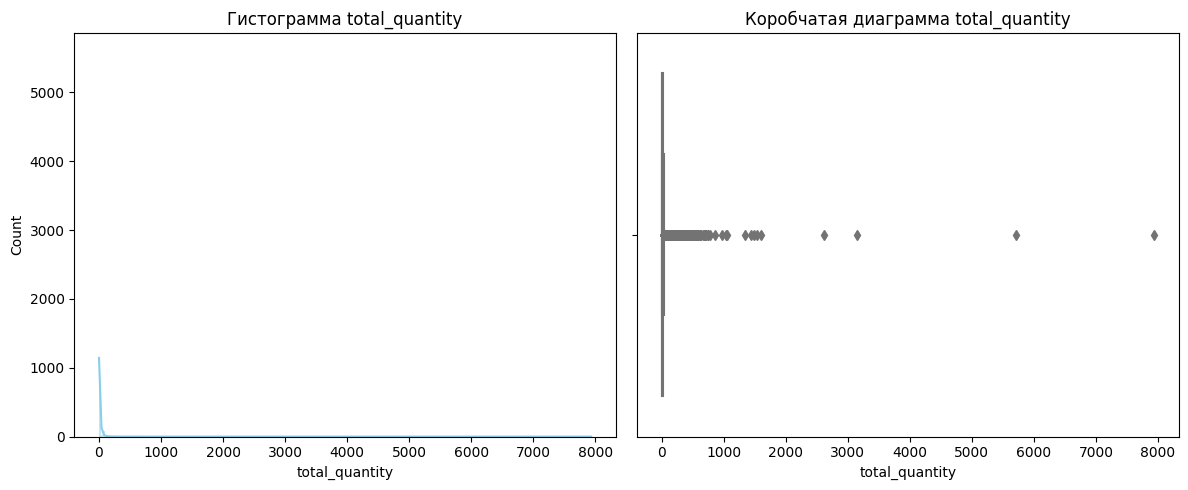

Визуализация признака: total_spent


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


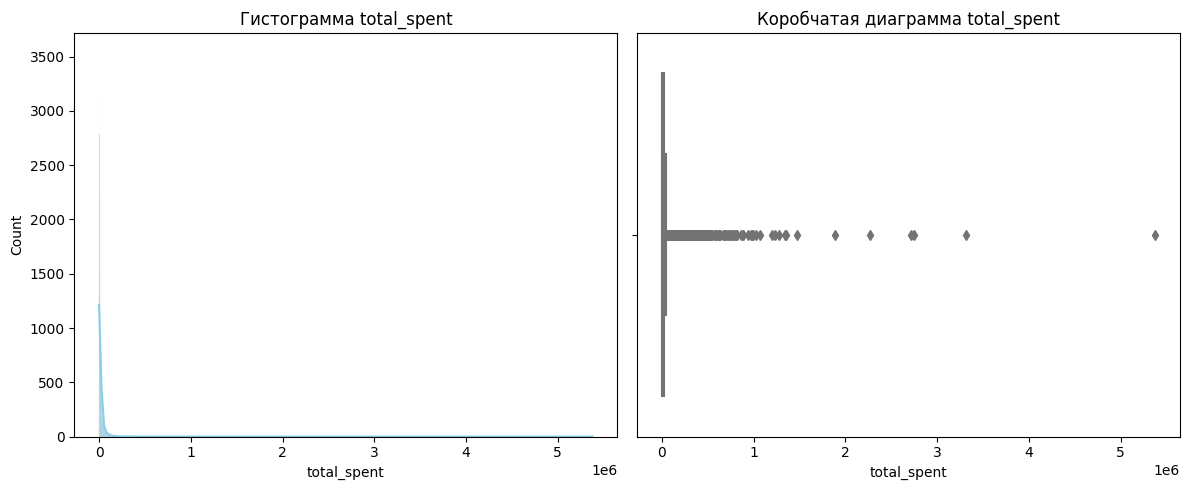

Визуализация признака: avg_price


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


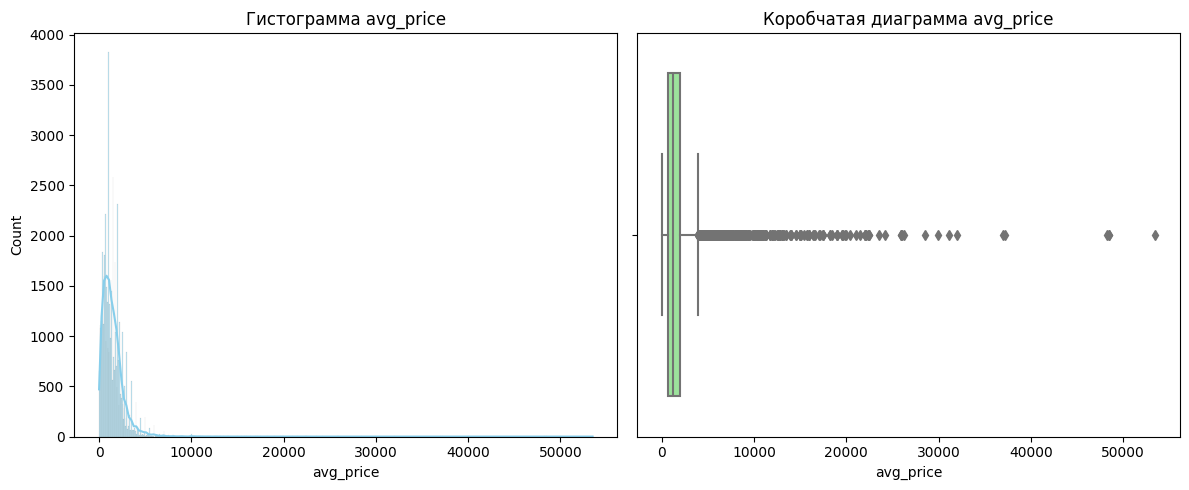

Визуализация признака: max_price


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


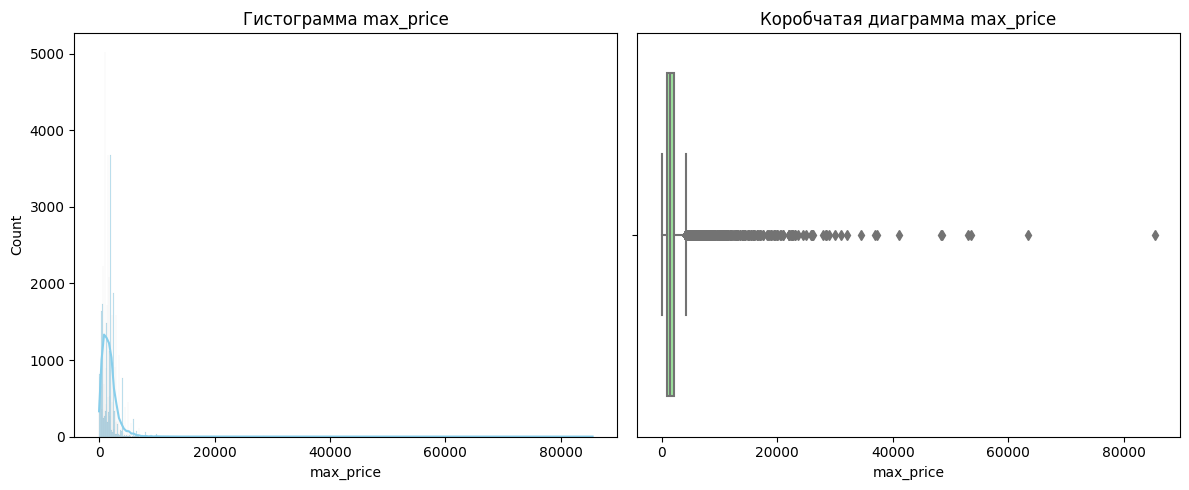

Визуализация признака: total_clicks


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


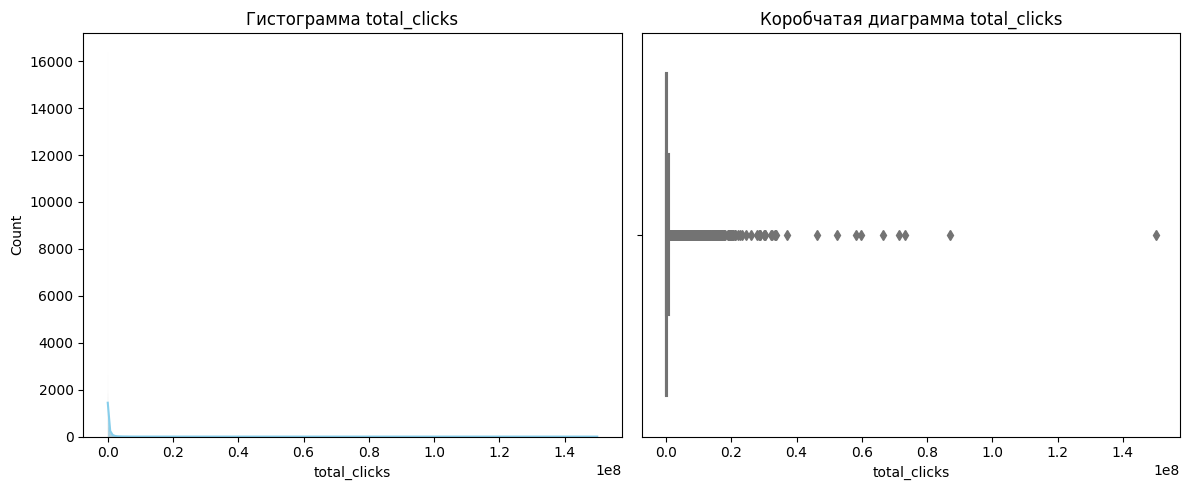

Визуализация признака: total_purchases


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


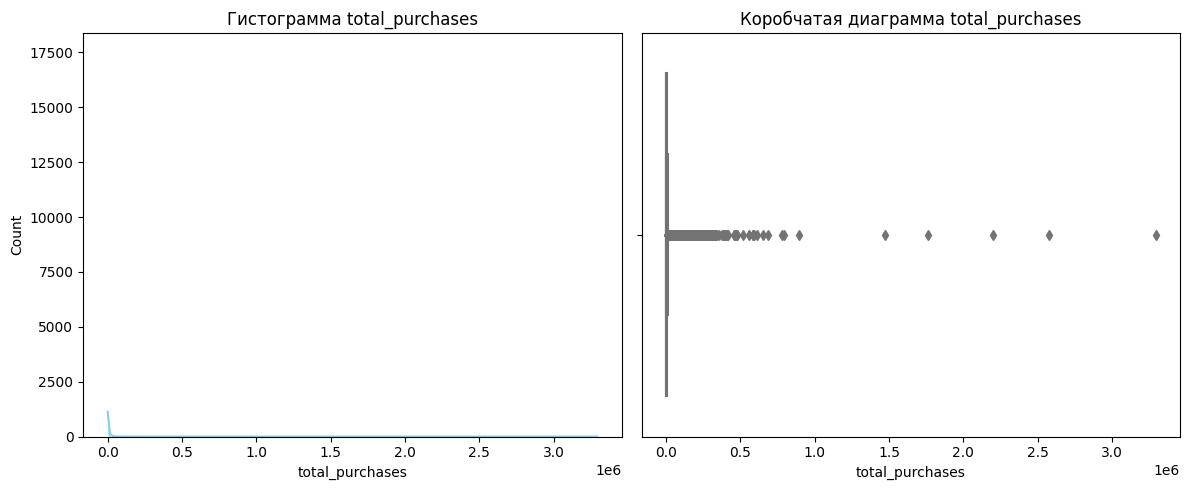

Визуализация признака: total_opens


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


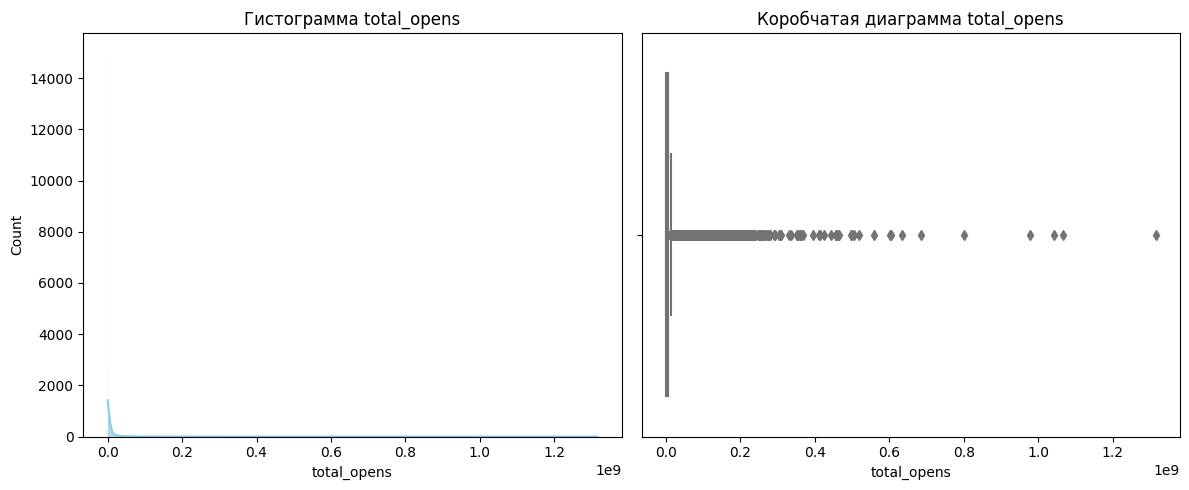

Визуализация признака: days_since_last_purchase


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


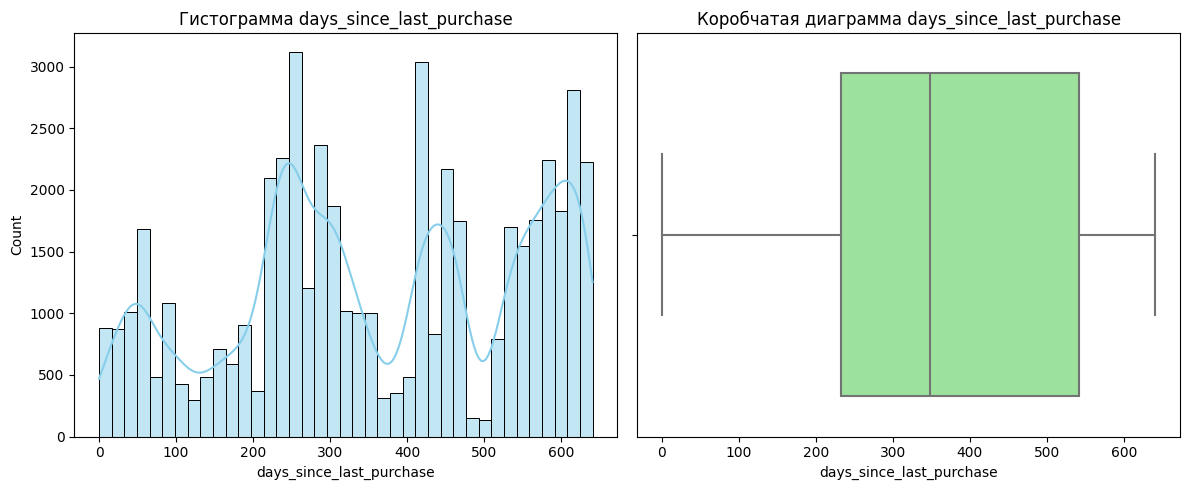

In [69]:
for feature in numerical_cols:
    print(f"Визуализация признака: {feature}")
    plot_numerical_feature(final_data, feature)

In [70]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   total_quantity            49849 non-null  int64         
 2   total_spent               49849 non-null  float64       
 3   avg_price                 49849 non-null  float64       
 4   max_price                 49849 non-null  float64       
 5   last_purchase_date        49849 non-null  datetime64[ns]
 6   has_interaction           49849 non-null  int64         
 7   event                     49849 non-null  object        
 8   channel                   49849 non-null  object        
 9   total_clicks              49849 non-null  float64       
 10  total_purchases           49849 non-null  float64       
 11  total_opens               49849 non-null  float64       
 12  category_emb_0    

Визуализация признака: event


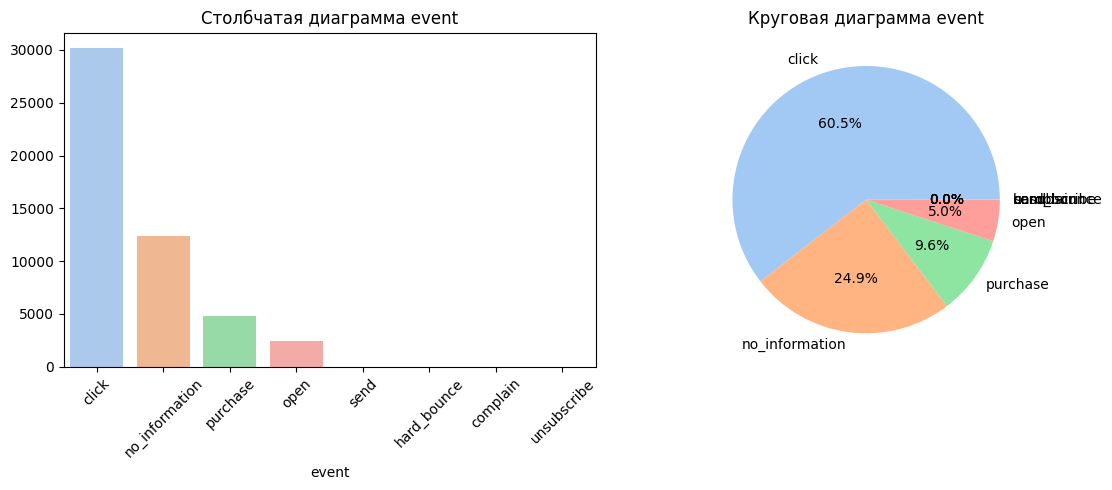

Визуализация признака: channel


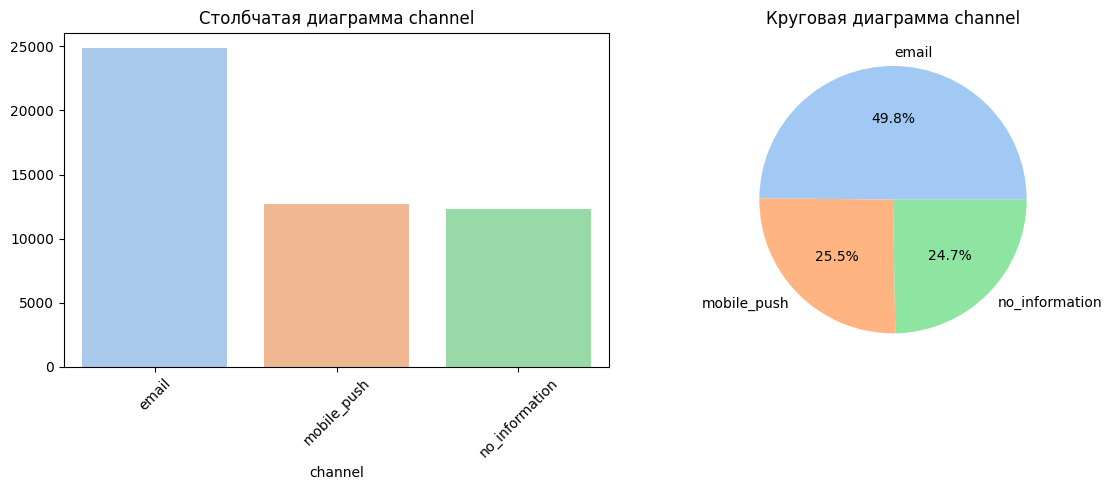

Визуализация признака: has_interaction


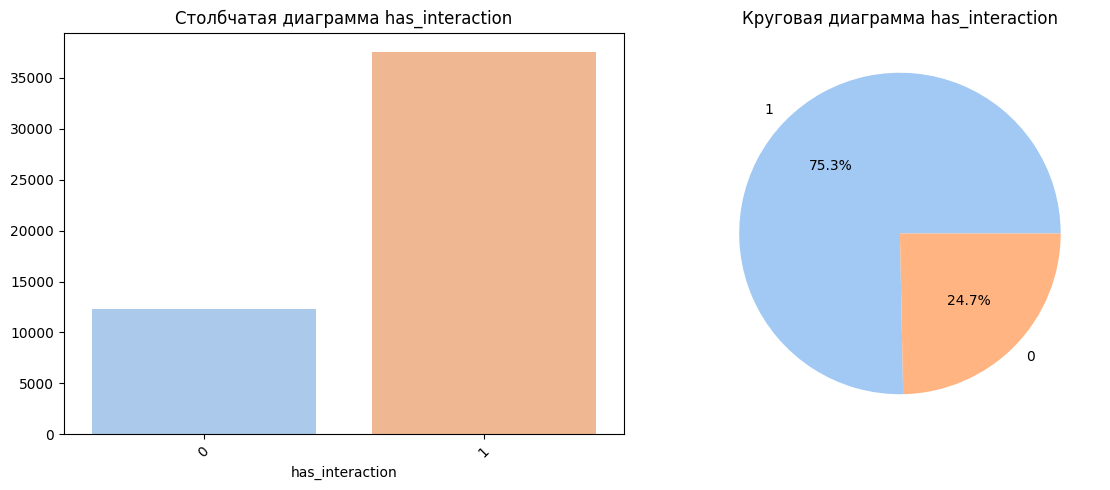

Визуализация признака: target


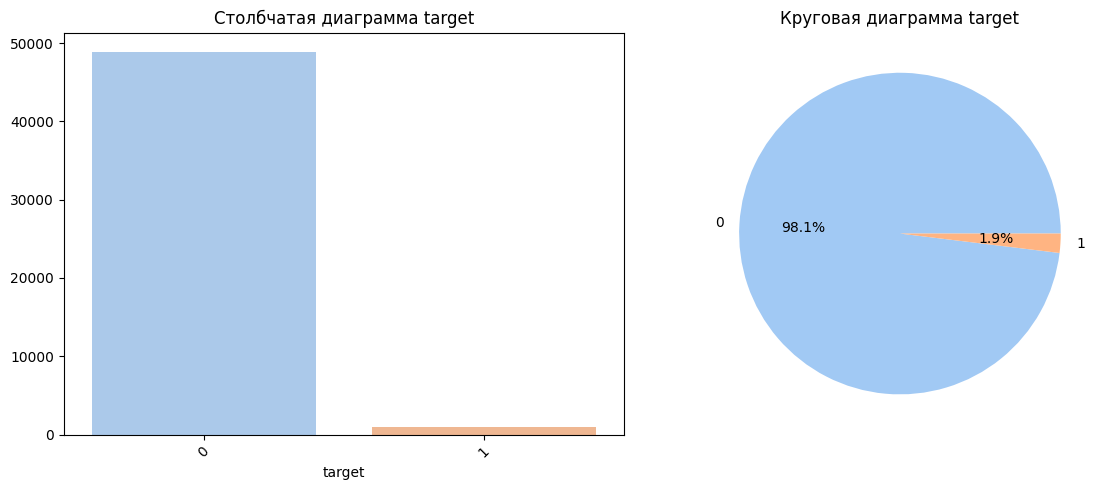

In [71]:
for feature in categorical_cols:
    print(f"Визуализация признака: {feature}")
    plot_categorical_feature(final_data, feature)

In [72]:
cols_no_emb = list(final_data.columns.drop(embedding_cols).drop('client_id'))

In [73]:
top_10_frequent_values(final_data,cols_no_emb)


Топ 10 частых значений в % total_quantity:



total_quantity
4     11.215872
8      9.105499
6      8.951032
2      8.134566
3      6.148569
12     5.883769
1      4.591867
5      4.543722
10     4.298983
16     3.374190
Name: proportion, dtype: float64


Топ 10 частых значений в % total_spent:



total_spent
3996.0    1.053181
7996.0    0.876647
5996.0    0.818472
2997.0    0.513551
5997.0    0.505527
9995.0    0.505527
4995.0    0.499509
1999.0    0.449357
999.0     0.445345
9996.0    0.445345
Name: proportion, dtype: float64


Топ 10 частых значений в % avg_price:



avg_price
999.0     4.509619
1999.0    3.998074
1499.0    3.845614
699.0     1.951895
2499.0    1.839555
599.0     1.825513
2199.0    1.570744
1299.0    1.490501
2999.0    1.462416
1699.0    1.446368
Name: proportion, dtype: float64


Топ 10 частых значений в % max_price:



max_price
999.0     7.037253
1999.0    6.989107
1499.0    6.335132
2499.0    3.618929
2999.0    3.081306
599.0     2.981003
2199.0    2.842585
699.0     2.818512
1299.0    2.306967
1699.0    2.292925
Name: proportion, dtype: float64


Топ 10 частых значений в % last_purchase_date:



last_purchase_date
2022-11-11    1.803446
2023-06-10    1.612871
2023-04-28    1.446368
2022-06-02    1.115368
2022-12-21    1.083271
2022-07-08    1.031114
2022-06-03    1.019078
2022-11-15    0.966920
2022-11-12    0.948866
2023-11-10    0.948866
Name: proportion, dtype: float64


Топ 10 частых значений в % has_interaction:



has_interaction
1    75.317459
0    24.682541
Name: proportion, dtype: float64


Топ 10 частых значений в % event:



event
click             60.468615
no_information    24.871111
purchase           9.629080
open               4.985055
send               0.038115
hard_bounce        0.004012
complain           0.002006
unsubscribe        0.002006
Name: proportion, dtype: float64


Топ 10 частых значений в % channel:



channel
email             49.826476
mobile_push       25.450862
no_information    24.722662
Name: proportion, dtype: float64


Топ 10 частых значений в % total_clicks:



total_clicks
0.0         24.682541
336868.0     0.411242
178408.0     0.308933
27699.0      0.290878
69928.0      0.274830
383512.0     0.264800
225692.0     0.252763
224088.0     0.238721
69172.0      0.236715
199956.0     0.218660
Name: proportion, dtype: float64


Топ 10 частых значений в % total_purchases:



total_purchases
0.0        24.686553
9976.0      0.411242
240.0       0.324981
4412.0      0.310939
1065.0      0.294891
3864.0      0.278842
12200.0     0.264800
5348.0      0.258782
120.0       0.258782
276.0       0.246745
Name: proportion, dtype: float64


Топ 10 частых значений в % total_opens:



total_opens
0.0          24.686553
2006472.0     0.411242
1814036.0     0.308933
1273980.0     0.290878
394012.0      0.274830
2905536.0     0.264800
6146712.0     0.252763
1527768.0     0.238721
212584.0      0.236715
1545344.0     0.218660
Name: proportion, dtype: float64


Топ 10 частых значений в % days_since_last_purchase:



days_since_last_purchase
462    1.803446
251    1.612871
294    1.446368
624    1.115368
422    1.083271
588    1.031114
623    1.019078
458    0.966920
461    0.948866
98     0.948866
Name: proportion, dtype: float64


Топ 10 частых значений в % target:



target
0    98.072178
1     1.927822
Name: proportion, dtype: float64

# Корреляция 

interval columns not set, guessing: ['total_quantity', 'total_spent', 'avg_price', 'max_price', 'has_interaction', 'total_clicks', 'total_purchases', 'total_opens', 'days_since_last_purchase', 'target']


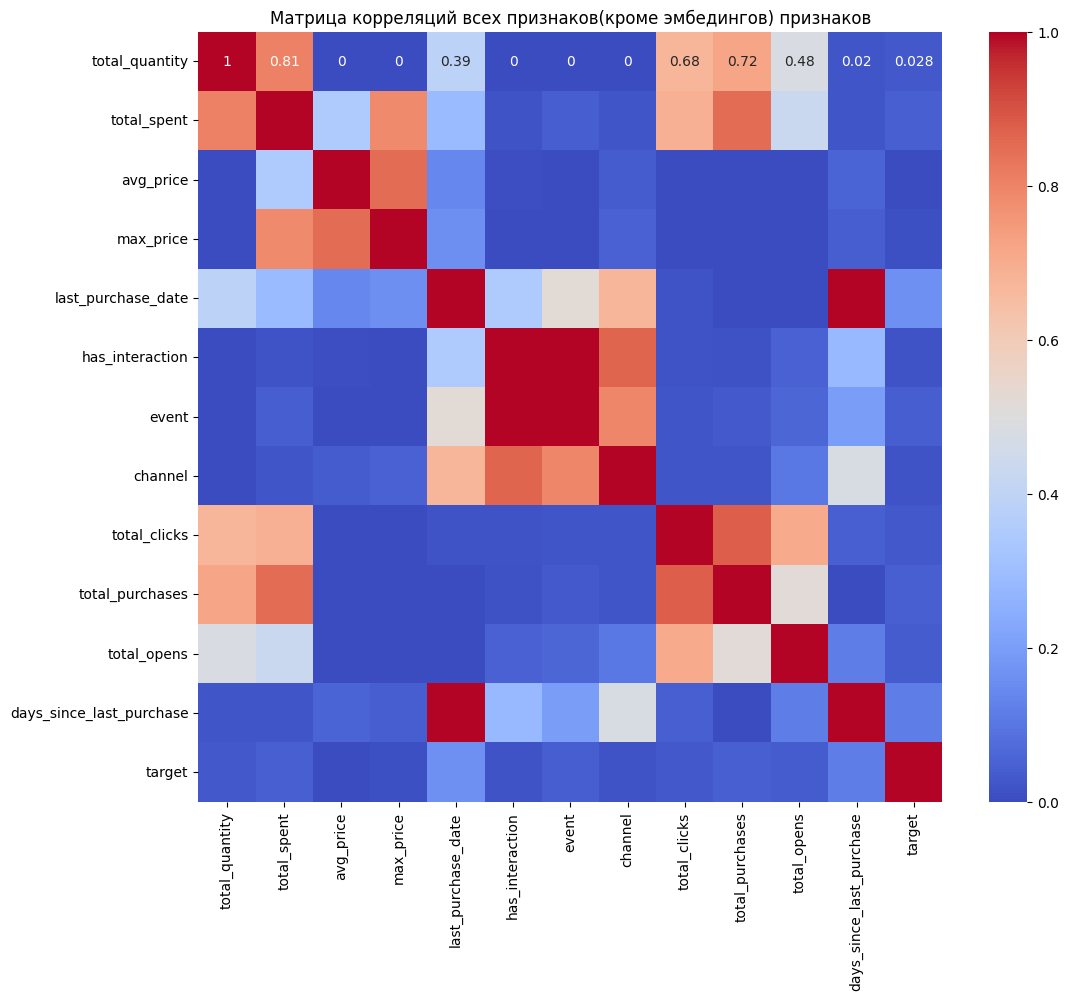

In [74]:
plt.figure(figsize=(12, 10))
corr_matrix = phik_matrix(final_data[cols_no_emb],njobs=-1)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций всех признаков(кроме эмбедингов) признаков')
plt.show()

In [75]:
corr_matrix

,total_quantity,total_spent,avg_price,max_price,last_purchase_date,has_interaction,event,channel,total_clicks,total_purchases,total_opens,days_since_last_purchase,target
total_quantity,1.000000,0.807913,0.000000,0.000000,0.386880,0.000000,0.000000,0.000000,0.675706,0.721259,0.480733,0.020400,0.027613
total_spent,0.807913,1.000000,0.351423,0.786722,0.287398,0.017978,0.040547,0.021554,0.688706,0.849067,0.429765,0.021330,0.043549
avg_price,0.000000,0.351423,1.000000,0.848078,0.139710,0.003986,0.000000,0.038489,0.000000,0.000000,0.000000,0.058118,0.000000
max_price,0.000000,0.786722,0.848078,1.000000,0.157377,0.000000,0.000000,0.050149,0.000000,0.000000,0.000000,0.042594,0.009358
last_purchase_date,0.386880,0.287398,0.139710,0.157377,1.000000,0.347721,0.519799,0.673388,0.016346,0.000000,0.000000,1.000000,0.163991
has_interaction,0.000000,0.017978,0.003986,0.000000,0.347721,1.000000,0.999969,0.865780,0.017408,0.015154,0.046896,0.284178,0.017621
event,0.000000,0.040547,0.000000,0.000000,0.519799,0.999969,1.000000,0.795832,0.023183,0.031946,0.062146,0.197255,0.039536
channel,0.000000,0.021554,0.038489,0.050149,0.673388,0.865780,0.795832,1.000000,0.023371,0.022622,0.102375,0.478768,0.017243
total_clicks,0.675706,0.688706,0.000000,0.000000,0.016346,0.017408,0.023183,0.023371,1.000000,0.877889,0.703805,0.045397,0.029282
total_purchases,0.721259,0.849067,0.000000,0.000000,0.000000,0.015154,0.031946,0.022622,0.877889,1.000000,0.518283,0.000000,0.043625


На основе пполученной матрицы корреляций можно сделать несколько ключевых выводов:

### 1. **Сильные корреляции:**
   - **total_quantity и total_spent (0.81)**: Эта сильная положительная корреляция указывает на то, что чем больше товаров покупает клиент, тем больше он тратит. Это логично, поскольку количество напрямую влияет на общие затраты.
   - **total_spent и max_price (0.79)**: Сильная связь между общими расходами и максимальной ценой указывает на то, что чем выше максимальная цена товара, тем выше общие затраты клиента.
   - **avg_price и max_price (0.85)**: Сильная корреляция между средней ценой и максимальной ценой товара говорит о том, что эти метрики взаимозависимы, и рост максимальной цены часто приводит к увеличению средней.
   - **total_clicks и total_purchases (0.88)**: Эта высокая корреляция свидетельствует о том, что клиенты, которые совершают больше кликов, склонны совершать больше покупок.
   - **event и has_interaction (0.999)**: Почти полная корреляция указывает на то, что события взаимодействия клиентов тесно связаны с самим фактом взаимодействия, что очевидно.

### 2. **Средние корреляции:**
   - **total_clicks и total_spent (0.69)**: Клиенты, которые больше кликают, как правило, тратят больше денег. Это свидетельствует о том, что активное взаимодействие с контентом связано с увеличением трат.
   - **total_opens и total_clicks (0.70)**: Этот показатель говорит о том, что клиенты, открывающие больше писем, также совершают больше кликов, что свидетельствует о взаимосвязи этих действий.
   - **days_since_last_purchase и channel (0.48)**: Клиенты, использующие определенные каналы, могут иметь различную частоту покупок.

### 3. **Слабые корреляции с целевой переменной (target):**
   - **days_since_last_purchase и target (0.12)**: Слабая положительная корреляция показывает, что чем больше времени прошло с последней покупки, тем выше вероятность достижения целевой переменной. Это может указывать на то, что определенные клиенты, которые не совершали покупок долгое время, все же имеют потенциал для повторных покупок.
   - **total_spent и target (0.04)**: Небольшая корреляция показывает, что общие расходы клиента не сильно связаны с целевой переменной.
   - **has_interaction и target (0.018)**: Практически отсутствие связи между взаимодействием клиента и целевой переменной показывает, что взаимодействие не является ключевым фактором.

### 4. **Отсутствие значимой корреляции:**
   - Некоторые признаки, такие как **avg_price**, **max_price**, и **total_purchases**, практически не имеют корреляции с целевой переменной, что может говорить о том, что они не являются значимыми предикторами для этой задачи.

### 5. **Корреляция между взаимодействиями и событиями:**
   - **has_interaction и event (0.999)**: Эта корреляция подчеркивает, что события и взаимодействия клиентов тесно взаимосвязаны, и один признак может служить хорошей заменой другому в модели.

### Выводы:
- Признаки **total_quantity**, **total_spent**, **total_clicks**, и **total_purchases** имеют значительную корреляцию между собой, что может указывать на наличие избыточности в данных.
- **has_interaction и event** практически полностью коррелируют, что говорит о том, что один из этих признаков может быть исключен из модели, чтобы избежать мультиколлинеарности.
- Признаки, такие как **days_since_last_purchase** и **total_opens**, могут внести вклад в модель, так как они слабо, но положительно коррелируют с целевой переменной.


### Признаки, которые стоит оставить:
- **days_since_last_purchase**
- **total_spent**
- **total_quantity**
- **total_clicks**
- **event**
- **target**

Эти признаки предоставляют важную информацию о поведении клиентов и их взаимодействии с системой, что может улучшить точность модели.

In [76]:
X = final_data[numerical_cols]

X_with_constant = add_constant(X)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
vif["Feature"] = X_with_constant.columns

print(vif.sort_values(by="VIF Factor", ascending=False))

   VIF Factor                   Feature
0    6.551323                     const
4    6.369401                 max_price
3    5.670004                 avg_price
5    3.641809              total_clicks
6    2.761143           total_purchases
2    2.156959               total_spent
1    2.068705            total_quantity
7    1.645578               total_opens
8    1.058862  days_since_last_purchase


In [77]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   total_quantity            49849 non-null  int64         
 2   total_spent               49849 non-null  float64       
 3   avg_price                 49849 non-null  float64       
 4   max_price                 49849 non-null  float64       
 5   last_purchase_date        49849 non-null  datetime64[ns]
 6   has_interaction           49849 non-null  int64         
 7   event                     49849 non-null  object        
 8   channel                   49849 non-null  object        
 9   total_clicks              49849 non-null  float64       
 10  total_purchases           49849 non-null  float64       
 11  total_opens               49849 non-null  float64       
 12  category_emb_0    

In [78]:
final_data = final_data.drop(columns=['max_price'])

In [79]:
vif_cols = final_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [80]:
vif_cols = [col for col in vif_cols if col not in embedding_cols and col != 'client_id' and col!='has_interaction'and col!='target']

In [81]:
vif_cols

['total_quantity',
 'total_spent',
 'avg_price',
 'total_clicks',
 'total_purchases',
 'total_opens',
 'days_since_last_purchase']

In [82]:
X_new = final_data[vif_cols]

X_n_c = add_constant(X_new)

In [83]:
new_vif = pd.DataFrame() 
new_vif["VIF Factor"] = [variance_inflation_factor(X_n_c.values, i) for i in range(X_n_c.shape[1])]
new_vif["Feature"] = X_n_c.columns

print(new_vif.sort_values(by="VIF Factor", ascending=False))

   VIF Factor                   Feature
0    6.320175                     const
4    3.641773              total_clicks
5    2.759924           total_purchases
1    2.038182            total_quantity
2    1.822455               total_spent
6    1.643616               total_opens
3    1.141233                 avg_price
7    1.050276  days_since_last_purchase


После удаления признака max_price, VIF (Variance Inflation Factor) для остальных признаков значительно снизился, что указывает на уменьшение мультиколлинеарности в данных.

# Трейн модельки

In [89]:
numerical_cols = vif_cols

In [90]:
num_cols_to_scale = [col for col in numerical_cols if col not in embedding_cols]

In [91]:
scaler = StandardScaler()
final_data[num_cols_to_scale] = scaler.fit_transform(final_data[num_cols_to_scale])

In [93]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 63 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   total_quantity            49849 non-null  float64       
 2   total_spent               49849 non-null  float64       
 3   avg_price                 49849 non-null  float64       
 4   last_purchase_date        49849 non-null  datetime64[ns]
 5   has_interaction           49849 non-null  int64         
 6   event                     49849 non-null  object        
 7   channel                   49849 non-null  object        
 8   total_clicks              49849 non-null  float64       
 9   total_purchases           49849 non-null  float64       
 10  total_opens               49849 non-null  float64       
 11  category_emb_0            49849 non-null  float64       
 12  category_emb_1    

In [94]:
categorical_cols = ['event', 'channel']

ohe = OneHotEncoder(drop='first', sparse=False)
ohe_encoded = ohe.fit_transform(final_data[categorical_cols])
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_feature_names, index=final_data.index)
final_data = pd.concat([final_data.drop(columns=categorical_cols), ohe_df], axis=1)


c:\Users\godcl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [95]:
X = final_data.drop(columns=['client_id', 'target', 'last_purchase_date'])
y = final_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [104]:
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Проверка нового распределения классов
print("Распределение классов после SMOTE:", Counter(y_train_smote))

Распределение классов после SMOTE: Counter({0: 39110, 1: 11733})


In [117]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    return roc_auc


In [119]:
def optimize_model(trial, model_name):
    if model_name == 'catboost':
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'eval_metric': 'AUC',
            'random_state': 42,
            'verbose': False
        }
        model = CatBoostClassifier(**params)
    elif model_name == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100, log=True),
            'gamma': trial.suggest_float('gamma', 0, 10),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'random_state': 42,
            'use_label_encoder': False,
            'eval_metric': 'auc'
        }
        model = XGBClassifier(**params)
    elif model_name == 'lightgbm':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', -1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 31, 256),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'random_state': 42,
            'metric': 'auc'
        }
        model = LGBMClassifier(**params)
    
    model.fit(X_train_smote, y_train_smote)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    return auc

In [120]:
models = ['catboost', 'xgboost', 'lightgbm']
best_models = {}
for model_name in models:
    print(f"\nОптимизация гиперпараметров для {model_name}")
    study = optuna.create_study(direction='maximize')
    func = lambda trial: optimize_model(trial, model_name)
    study.optimize(func, n_trials=30)
    best_params = study.best_trial.params
    print(f"Лучшие параметры для {model_name}: {best_params}")
    
    # Обучаем модель с лучшими параметрами
    if model_name == 'catboost':
        best_model = CatBoostClassifier(**best_params)
    elif model_name == 'xgboost':
        best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='auc')
    elif model_name == 'lightgbm':
        best_model = LGBMClassifier(**best_params)
    
    print(f"\nОценка модели {model_name}")
    auc = train_and_evaluate_model(best_model, X_train_smote, y_train_smote, X_test, y_test)
    best_models[model_name] = (best_model, auc)

[I 2024-10-01 17:22:33,078] A new study created in memory with name: no-name-730be700-b696-47f9-a85b-b5b537bd0f2d



Оптимизация гиперпараметров для catboost


[I 2024-10-01 17:25:05,704] Trial 0 finished with value: 0.6470744272857436 and parameters: {'iterations': 960, 'depth': 10, 'learning_rate': 0.11262974966500366, 'l2_leaf_reg': 2.145692860342127, 'border_count': 197, 'random_strength': 3.5854187947978353e-09, 'bagging_temperature': 0.1467189686176802}. Best is trial 0 with value: 0.6470744272857436.
[I 2024-10-01 17:25:56,500] Trial 1 finished with value: 0.6729871906320312 and parameters: {'iterations': 875, 'depth': 9, 'learning_rate': 0.014510854806652849, 'l2_leaf_reg': 0.0065761877620321325, 'border_count': 131, 'random_strength': 5.837243607838704e-07, 'bagging_temperature': 0.5381849520497601}. Best is trial 1 with value: 0.6729871906320312.
[I 2024-10-01 17:26:25,363] Trial 2 finished with value: 0.6943840764982615 and parameters: {'iterations': 614, 'depth': 9, 'learning_rate': 0.0015814340347272563, 'l2_leaf_reg': 0.1559241312304572, 'border_count': 95, 'random_strength': 3.6214874011719265e-07, 'bagging_temperature': 0.5824

Лучшие параметры для catboost: {'iterations': 243, 'depth': 5, 'learning_rate': 0.014969340550289048, 'l2_leaf_reg': 0.14832583401732205, 'border_count': 233, 'random_strength': 0.014904061002525256, 'bagging_temperature': 0.37947421223144}

Оценка модели catboost
0:	learn: 0.6816735	total: 26.7ms	remaining: 6.46s
1:	learn: 0.6708068	total: 45.4ms	remaining: 5.47s
2:	learn: 0.6604513	total: 64.3ms	remaining: 5.14s
3:	learn: 0.6512166	total: 82.3ms	remaining: 4.92s
4:	learn: 0.6418824	total: 107ms	remaining: 5.08s
5:	learn: 0.6327344	total: 129ms	remaining: 5.09s
6:	learn: 0.6260668	total: 155ms	remaining: 5.24s
7:	learn: 0.6179104	total: 190ms	remaining: 5.57s
8:	learn: 0.6116673	total: 219ms	remaining: 5.69s
9:	learn: 0.6059611	total: 248ms	remaining: 5.78s
10:	learn: 0.6001224	total: 270ms	remaining: 5.7s
11:	learn: 0.5935470	total: 292ms	remaining: 5.61s
12:	learn: 0.5886181	total: 316ms	remaining: 5.6s
13:	learn: 0.5812235	total: 345ms	remaining: 5.64s
14:	learn: 0.5744224	total: 3

[I 2024-10-01 17:31:50,528] A new study created in memory with name: no-name-960f45a9-3205-47fa-8bb2-ca2b0678cf8d


240:	learn: 0.2977072	total: 6.28s	remaining: 52.1ms
241:	learn: 0.2975492	total: 6.3s	remaining: 26ms
242:	learn: 0.2967046	total: 6.32s	remaining: 0us
ROC AUC Score: 0.7142
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9778
           1       0.13      0.01      0.02       192

    accuracy                           0.98      9970
   macro avg       0.56      0.50      0.50      9970
weighted avg       0.96      0.98      0.97      9970


Оптимизация гиперпараметров для xgboost


[I 2024-10-01 17:31:56,389] Trial 0 finished with value: 0.6599916585702598 and parameters: {'n_estimators': 776, 'max_depth': 5, 'learning_rate': 0.2993820722391719, 'reg_alpha': 0.0001947432114518924, 'reg_lambda': 2.1681603308298116e-05, 'gamma': 5.19084823947238, 'colsample_bytree': 0.6530368235028485, 'subsample': 0.9829233578883052}. Best is trial 0 with value: 0.6599916585702598.
[I 2024-10-01 17:32:02,924] Trial 1 finished with value: 0.676491017249608 and parameters: {'n_estimators': 427, 'max_depth': 9, 'learning_rate': 0.04430404100860176, 'reg_alpha': 0.00036954600843005126, 'reg_lambda': 31.78046617974348, 'gamma': 8.668043479293734, 'colsample_bytree': 0.9907991361708426, 'subsample': 0.8399421920397108}. Best is trial 1 with value: 0.676491017249608.
[I 2024-10-01 17:32:12,266] Trial 2 finished with value: 0.6811515114713301 and parameters: {'n_estimators': 404, 'max_depth': 7, 'learning_rate': 0.03268383932838509, 'reg_alpha': 11.24718860246752, 'reg_lambda': 1.13427416

Лучшие параметры для xgboost: {'n_estimators': 710, 'max_depth': 6, 'learning_rate': 0.07450524174846282, 'reg_alpha': 56.23656128556014, 'reg_lambda': 1.3234475151095841, 'gamma': 2.755949268988398, 'colsample_bytree': 0.7799390620266414, 'subsample': 0.638276789031198}

Оценка модели xgboost


[I 2024-10-01 17:35:37,057] A new study created in memory with name: no-name-c57689b2-f343-41b4-a461-cddd90589845


ROC AUC Score: 0.7002
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9778
           1       0.13      0.06      0.08       192

    accuracy                           0.97      9970
   macro avg       0.55      0.52      0.53      9970
weighted avg       0.97      0.97      0.97      9970


Оптимизация гиперпараметров для lightgbm
[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2024-10-01 17:35:44,150] Trial 0 finished with value: 0.6566569509783868 and parameters: {'n_estimators': 899, 'max_depth': 8, 'learning_rate': 0.09640609125255915, 'num_leaves': 35, 'reg_alpha': 0.011924953774913285, 'reg_lambda': 2.1819333239712675e-05, 'colsample_bytree': 0.6600963846051751, 'subsample': 0.6382275654201754}. Best is trial 0 with value: 0.6566569509783868.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973


[I 2024-10-01 17:35:44,958] Trial 1 finished with value: 0.6837815120679076 and parameters: {'n_estimators': 202, 'max_depth': 1, 'learning_rate': 0.04403214612216242, 'num_leaves': 205, 'reg_alpha': 0.21181135913942037, 'reg_lambda': 0.8976883138150777, 'colsample_bytree': 0.6138187586661683, 'subsample': 0.8685027409358083}. Best is trial 1 with value: 0.6837815120679076.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:35:50,728] Trial 2 finished with value: 0.6966167139667281 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.018545077463256374, 'num_leaves': 218, 'reg_alpha': 8.596736633074098, 'reg_lambda': 6.141567483109509e-05, 'colsample_bytree': 0.7586454991225373, 'subsample': 0.6534840357176857}. Best is trial 2 with value: 0.6966167139667281.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:06,499] Trial 3 finished with value: 0.6670022414263312 and parameters: {'n_estimators': 633, 'max_depth': 9, 'learning_rate': 0.001063293522879322, 'num_leaves': 249, 'reg_alpha': 0.01287023379172943, 'reg_lambda': 4.667731332967241, 'colsample_bytree': 0.8734145746448028, 'subsample': 0.8148408347902656}. Best is trial 2 with value: 0.6966167139667281.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973


[I 2024-10-01 17:36:09,140] Trial 4 finished with value: 0.6887530787652554 and parameters: {'n_estimators': 665, 'max_depth': 2, 'learning_rate': 0.009262124598758647, 'num_leaves': 187, 'reg_alpha': 6.582421264474307, 'reg_lambda': 0.0068156649055576566, 'colsample_bytree': 0.8347096082901568, 'subsample': 0.7107143514355865}. Best is trial 2 with value: 0.6966167139667281.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:15,314] Trial 5 finished with value: 0.6927160568793891 and parameters: {'n_estimators': 667, 'max_depth': 6, 'learning_rate': 0.016604326679456397, 'num_leaves': 87, 'reg_alpha': 0.0001601017171706918, 'reg_lambda': 0.02510553995261485, 'colsample_bytree': 0.8070463728046899, 'subsample': 0.8925143516616763}. Best is trial 2 with value: 0.6966167139667281.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:17,558] Trial 6 finished with value: 0.7056580567771187 and parameters: {'n_estimators': 567, 'max_depth': 3, 'learning_rate': 0.03540139750838737, 'num_leaves': 76, 'reg_alpha': 6.753445330838519, 'reg_lambda': 0.2680546002896304, 'colsample_bytree': 0.5878203894406757, 'subsample': 0.791671518000151}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:20,791] Trial 7 finished with value: 0.6727400371582464 and parameters: {'n_estimators': 375, 'max_depth': 4, 'learning_rate': 0.0012473902540326032, 'num_leaves': 124, 'reg_alpha': 3.6433603763678886e-05, 'reg_lambda': 0.002048614962148876, 'colsample_bytree': 0.883384843484959, 'subsample': 0.7149572561801381}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973


[I 2024-10-01 17:36:23,557] Trial 8 finished with value: 0.690740693393332 and parameters: {'n_estimators': 772, 'max_depth': 2, 'learning_rate': 0.009183124033166198, 'num_leaves': 126, 'reg_alpha': 0.0030446991124509003, 'reg_lambda': 0.00025705947357034355, 'colsample_bytree': 0.7751019996645363, 'subsample': 0.7907640188834193}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:27,714] Trial 9 finished with value: 0.6822290793106975 and parameters: {'n_estimators': 656, 'max_depth': 4, 'learning_rate': 0.002513543417985599, 'num_leaves': 245, 'reg_alpha': 1.1364093403666073e-05, 'reg_lambda': 1.961991817141653e-05, 'colsample_bytree': 0.6968655314354344, 'subsample': 0.9851765931685263}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:29,044] Trial 10 finished with value: 0.6829042237676417 and parameters: {'n_estimators': 183, 'max_depth': -1, 'learning_rate': 0.1690229124474923, 'num_leaves': 36, 'reg_alpha': 49.3076120522741, 'reg_lambda': 36.675495628003446, 'colsample_bytree': 0.5188708866630309, 'subsample': 0.528226538171741}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-10-01 17:36:35,216] Trial 11 finished with value: 0.6655491494511487 and parameters: {'n_estimators': 449, 'max_depth': 7, 'learning_rate': 0.04188198312473482, 'num_leaves': 175, 'reg_alpha': 0.9544056205748054, 'reg_lambda': 0.3731965721435565, 'colsample_bytree': 0.9824689777738813, 'subsample': 0.6046986713465824}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:39,133] Trial 12 finished with value: 0.685143785794641 and parameters: {'n_estimators': 343, 'max_depth': 10, 'learning_rate': 0.03474846528386053, 'num_leaves': 79, 'reg_alpha': 35.55294219663368, 'reg_lambda': 0.21676381402597658, 'colsample_bytree': 0.5482471962765953, 'subsample': 0.6629200674920097}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:44,030] Trial 13 finished with value: 0.6890971760584987 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.00502124009652665, 'num_leaves': 156, 'reg_alpha': 1.3711456157583461, 'reg_lambda': 0.00036291562524509447, 'colsample_bytree': 0.7146946115098245, 'subsample': 0.5553255438095367}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:46,417] Trial 14 finished with value: 0.695608125383514 and parameters: {'n_estimators': 338, 'max_depth': 5, 'learning_rate': 0.01984264078816518, 'num_leaves': 84, 'reg_alpha': 0.19046973776448842, 'reg_lambda': 0.06092791833276284, 'colsample_bytree': 0.591573642149791, 'subsample': 0.7608092709171377}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:36:50,720] Trial 15 finished with value: 0.6908331096168269 and parameters: {'n_estimators': 988, 'max_depth': 3, 'learning_rate': 0.09051590601286169, 'num_leaves': 209, 'reg_alpha': 6.047237230208893, 'reg_lambda': 12.103004681193934, 'colsample_bytree': 0.6516564418400212, 'subsample': 0.8595625357980878}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973


[I 2024-10-01 17:37:00,800] Trial 16 finished with value: 0.6781672930728847 and parameters: {'n_estimators': 475, 'max_depth': 0, 'learning_rate': 0.01930045424913063, 'num_leaves': 113, 'reg_alpha': 8.33429642453461, 'reg_lambda': 0.0002762035508316989, 'colsample_bytree': 0.740836217465745, 'subsample': 0.9518151854527321}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:03,534] Trial 17 finished with value: 0.6852886688654803 and parameters: {'n_estimators': 807, 'max_depth': 10, 'learning_rate': 0.26091106541374387, 'num_leaves': 63, 'reg_alpha': 97.48730149565775, 'reg_lambda': 1.6216274446957846, 'colsample_bytree': 0.9324448892157842, 'subsample': 0.6973402101844233}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-10-01 17:37:10,150] Trial 18 finished with value: 0.6494910982136769 and parameters: {'n_estimators': 550, 'max_depth': 8, 'learning_rate': 0.07574470829845648, 'num_leaves': 151, 'reg_alpha': 0.160705864958096, 'reg_lambda': 0.0029193697333793215, 'colsample_bytree': 0.5600161268680438, 'subsample': 0.5800893307073957}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:12,016] Trial 19 finished with value: 0.6860708776505079 and parameters: {'n_estimators': 259, 'max_depth': 5, 'learning_rate': 0.0075899459337983016, 'num_leaves': 221, 'reg_alpha': 0.0009229451469623759, 'reg_lambda': 0.052755700628114376, 'colsample_bytree': 0.5025755755346041, 'subsample': 0.5028963303520123}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:14,687] Trial 20 finished with value: 0.681324359105475 and parameters: {'n_estimators': 570, 'max_depth': 3, 'learning_rate': 0.004428766328524207, 'num_leaves': 176, 'reg_alpha': 1.4302936425293657, 'reg_lambda': 7.152020498982619e-05, 'colsample_bytree': 0.6706351726439578, 'subsample': 0.7598189824842738}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:15,676] Trial 21 finished with value: 0.6819856544453535 and parameters: {'n_estimators': 102, 'max_depth': 5, 'learning_rate': 0.02242164018900434, 'num_leaves': 95, 'reg_alpha': 0.13552513646220538, 'reg_lambda': 0.03431643844048096, 'colsample_bytree': 0.6066918523813346, 'subsample': 0.7629192610353884}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:19,263] Trial 22 finished with value: 0.6939472966523488 and parameters: {'n_estimators': 365, 'max_depth': 7, 'learning_rate': 0.027659618926019876, 'num_leaves': 60, 'reg_alpha': 0.4559291623025957, 'reg_lambda': 0.1046381426469603, 'colsample_bytree': 0.5857525847592325, 'subsample': 0.8074208792894298}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:21,906] Trial 23 finished with value: 0.7022426514454216 and parameters: {'n_estimators': 288, 'max_depth': 6, 'learning_rate': 0.014129446154435794, 'num_leaves': 110, 'reg_alpha': 13.167349677691918, 'reg_lambda': 0.006562203612685529, 'colsample_bytree': 0.7662007128557279, 'subsample': 0.6537941609718341}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:25,186] Trial 24 finished with value: 0.6924036527578918 and parameters: {'n_estimators': 276, 'max_depth': 7, 'learning_rate': 0.012886287430928713, 'num_leaves': 105, 'reg_alpha': 16.50064709561079, 'reg_lambda': 0.010129079915936597, 'colsample_bytree': 0.7641922683268311, 'subsample': 0.6644587860967248}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:31,856] Trial 25 finished with value: 0.6689022337560511 and parameters: {'n_estimators': 432, 'max_depth': 8, 'learning_rate': 0.05497705011524201, 'num_leaves': 129, 'reg_alpha': 2.7175826693457132, 'reg_lambda': 0.0012220926003161019, 'colsample_bytree': 0.8133501577754362, 'subsample': 0.6224949745179786}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:36,443] Trial 26 finished with value: 0.7021582250971569 and parameters: {'n_estimators': 561, 'max_depth': 6, 'learning_rate': 0.012798919202673986, 'num_leaves': 64, 'reg_alpha': 17.1416990844801, 'reg_lambda': 6.281213197920646e-05, 'colsample_bytree': 0.7229259524135772, 'subsample': 0.667568731590938}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:42,805] Trial 27 finished with value: 0.6954014539442285 and parameters: {'n_estimators': 771, 'max_depth': 6, 'learning_rate': 0.005078289127569925, 'num_leaves': 56, 'reg_alpha': 22.5799974856334, 'reg_lambda': 0.011718688495162959, 'colsample_bytree': 0.7115307808265403, 'subsample': 0.7061057583861914}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:45,363] Trial 28 finished with value: 0.7000081496727346 and parameters: {'n_estimators': 553, 'max_depth': 3, 'learning_rate': 0.012813869254000103, 'num_leaves': 66, 'reg_alpha': 0.04413346110137685, 'reg_lambda': 0.0008857713621131949, 'colsample_bytree': 0.8650030313488869, 'subsample': 0.6034061055113855}. Best is trial 6 with value: 0.7056580567771187.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-10-01 17:37:50,090] Trial 29 finished with value: 0.6817885708563443 and parameters: {'n_estimators': 853, 'max_depth': 4, 'learning_rate': 0.0030257315808855027, 'num_leaves': 36, 'reg_alpha': 99.13402087158642, 'reg_lambda': 8.772043129522838e-05, 'colsample_bytree': 0.6460083550622217, 'subsample': 0.8294052303308046}. Best is trial 6 with value: 0.7056580567771187.


Лучшие параметры для lightgbm: {'n_estimators': 567, 'max_depth': 3, 'learning_rate': 0.03540139750838737, 'num_leaves': 76, 'reg_alpha': 6.753445330838519, 'reg_lambda': 0.2680546002896304, 'colsample_bytree': 0.5878203894406757, 'subsample': 0.791671518000151}

Оценка модели lightgbm
[LightGBM] [Info] Number of positive: 11733, number of negative: 39110
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15802
[LightGBM] [Info] Number of data points in the train set: 50843, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [121]:
# 9. Вывод результатов
print("\nСравнение моделей по ROC AUC:")
for model_name, (model, auc) in best_models.items():
    print(f"{model_name}: ROC AUC = {auc:.4f}")


Сравнение моделей по ROC AUC:
catboost: ROC AUC = 0.7142
xgboost: ROC AUC = 0.7002
lightgbm: ROC AUC = 0.7083


In [130]:
best_model_name = max(best_models, key=lambda x: best_models[x][1])
best_model, best_auc = best_models[best_model_name]

print(f"\nЛучшая модель: {best_model_name} с ROC AUC = {best_auc:.4f}")


Лучшая модель: catboost с ROC AUC = 0.7142


In [132]:
# Предсказания на тестовой выборке
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Выводим отчёт по классификации
print(f"\nОтчёт по классификации для модели {best_model_name}:")
print(classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


Отчёт по классификации для модели catboost:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9778
           1       0.13      0.01      0.02       192

    accuracy                           0.98      9970
   macro avg       0.56      0.50      0.50      9970
weighted avg       0.96      0.98      0.97      9970

ROC AUC Score: 0.7142


In [133]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
print(f"Матрица ошибок:\n{cm}")

Матрица ошибок:
[[9765   13]
 [ 190    2]]


Несмотря на применение SMOTE для балансировки обучающей выборки, модель всё ещё испытывает сложности с правильной классификацией положительного класса.

### **Обзор проделанной работы**

В ходе проекта была проведена комплексная работа по построению модели для прогнозирования возврата клиентов в течение 90 дней на основе имеющихся данных о покупках и взаимодействиях. Основные этапы работы включали:

1. **Предварительная обработка данных:**
   - Загрузка и объединение данных из различных источников.
   - Проверка и обработка пропущенных значений и дубликатов.
   - Выявление и обрезка выбросных значений в численных признаках.
   - Кодирование категориальных признаков.
   - Масштабирование числовых признаков.

2. **Разработка признаков:**
   - Использование эмбеддингов категорий товаров с помощью модели Word2Vec.
   - Агрегация эмбеддингов на уровне клиента.
   - Создание дополнительных временных признаков.

3. **Анализ данных (EDA):**
   - Визуализация распределений числовых признаков и анализ выбросов.
   - Исследование категориальных признаков и их влияния на целевую переменную.
   - Проверка корреляций и мультиколлинеарности между признаками.

4. **Обработка дисбаланса классов:**
   - Выявление сильного дисбаланса классов в целевой переменной (`target`).
   - Применение методов балансировки данных, включая SMOTE.

5. **Построение и оценка моделей:**
   - Обучение моделей CatBoost, XGBoost и LightGBM.
   - Оптимизация гиперпараметров с использованием Optuna.
   - Сравнение моделей по метрикам качества.

6. **Анализ результатов:**
   - Оценка метрик качества моделей (ROC AUC, precision, recall, f1-score).
   - Анализ матриц ошибок и выявление проблем с предсказанием положительного класса.

### **Полученные результаты**

- **Модель CatBoost показала лучший результат по метрике ROC AUC**, однако:
  - **Precision и Recall для положительного класса (клиенты, которые вернулись)** остались очень низкими.
  - **Модель не смогла эффективно распознать положительный класс**, что видно из матрицы ошибок и отчёта по классификации.
  
- **Применение SMOTE для балансировки данных** улучшило метрику ROC AUC, но не привело к значительному повышению качества предсказаний для положительного класса.

- **Сильный дисбаланс классов** (очень малое количество положительных примеров) остаётся основной проблемой для модели.

### **Рекомендации для улучшения модели**

#### **Улучшение качества данных**

- **Улучшенная загрузка данных и расширение датасета:**
  - **Сбор дополнительных данных** о клиентах и их поведении, чтобы увеличить количество положительных примеров.
  - **Проверка качества исходных данных**, устранение возможных ошибок и неточностей.
  - **Обогащение данных** за счёт внешних источников (если возможно), таких как данные о демографии, предпочтениях, социальных сетях и т.д.

- **Проверка и улучшение качества эмбеддингов:**
  - **Пересмотреть подход к обучению модели Word2Vec:**
    - Попробовать различные параметры модели (размер окна, количество эпох, размер эмбеддинга).
    - Убедиться, что категории товаров достаточно разнообразны и представлены в данных.
  - **Использовать более продвинутые модели для эмбеддингов**, такие как Doc2Vec или модели на основе трансформеров.

#### **Расширение и улучшение признаков**

- **Создание новых признаков (Feature Engineering):**
  - **Временные признаки:**
    - Частота покупок в разные периоды (7, 14, 30 дней).
    - Тренды покупательского поведения (увеличение или снижение активности).
    - Время суток и день недели покупок.
  - **Признаки взаимодействия:**
    - Количество открытий писем, кликов по ссылкам.
    - Реакция на маркетинговые кампании.
  - **Сегментация клиентов:**
    - Разделение клиентов на грпупы по поведению (например, RFM-анализ).
  
- **Анализ корреляций между признаками и целевой переменной:**
  - Выявление наиболее информативных признаков.
  - Исключение нерелевантных или дублирующих признаков.

#### **Обработка дисбаланса классов**

- **Применение альтернативных методов балансировки:**
  - **Использование комбинированных методов**, таких как SMOTEENN или SMOTETomek, для улучшения качества синтетических данных.
  - **Эксперименты с различными значениями `sampling_strategy`** в SMOTE.

- **Введение весов классов в модели:**
  - Настройка параметра `class_weight` в модлеях для усиления значимости положительного класса.
  - Использование специальных функций потерь, учитывающих дисбаланс классов.

- **Настройка порога классификации:**
  - Оптимизация порога вероятности для классификации, чтобы повысить `Recall` для положительного класса.
  - Использование метрик, основанных на Precision-Recall, вместо ROC AUC.

#### **Модели и алгоритмы**

- **Использование ансамблей моделей:**
  - Комбинация нескольких моделей для улучшения качества предсказаний.
  - Применение стекинга или бустинга на основе различных алгоритмов.

- **Применение алгоритмов, устойчивых к дисбалансу классов:**
  - **Balanced Random Forest**, **EasyEnsembleClassifier** из библиотеки `imblearn`.
  - **XGBoost** с параметром `scale_pos_weight`, настроенным на отношение количества отрицательных и положительных примеров.

#### **Валидация и переобучение**

- **Кросс-валидация с учетом временной составляющей:**
  - Разделение данных на обучающие и тестовые наборы по времени, чтобы модель училась на прошлых данных и предсказывала будущие.
  - Использование `TimeSeriesSplit` из `sklearn` для более реалистичной оценки модели.

Но самое важное - **наладить процесс сбора и передачи данных отделу дата-саенс**

- Улучшить качество и объем данных, особенно увеличить количество положительных примеров.
- Расширить и обогатить набор признаков, чтобы модель могла лучше различать классы.
- Применить более продвинутые методы обработки дисбаланса классов и настроить модели с учетом специфики данных.
- Провести дополнительные эксперименты с различными алгоритмами, метриками и подходами к валидации.